In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from IPython.display import display, HTML, IFrame
%matplotlib inline
from collections import defaultdict
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')


In [5]:
folder = ['compsci-data','jbt-data', 'brands-data-400', 'brands-data-100', 'brands-data-it2', 'jbt-data-it2', 'compsci-data-it2']
MERGE_OTHER = True
ut = 'brands'
#folder = ['{}-data-it2'.format(ut),  'brands-data-400', 'brands-data-100']
#folder = ['{}-data-it3'.format(ut)]

In [6]:


agg_list = []
full_list = []
test_list = []
for f in folder:
    agg =  pd.read_csv('{}/agg.csv'.format(f))
    agg['type'] = f.split('-')[0]
    agg.set_index('id')
    agg_list.append(agg)
   
    full = pd.read_csv('{}/full.csv'.format(f))
    full['type'] = f.split('-')[0]
    full.set_index('id')
    full_list.append( full)
    test = pd.read_csv('{}/test.csv'.format(f))
    test['type'] = f.split('-')[0]
    test.set_index('id')
    test_list.append (test)
aggregated = pd.concat(agg_list)
if MERGE_OTHER:
    aggregated['label'] = aggregated.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)
    full['label'] = full.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)


print(aggregated.describe())
full = pd.concat(full_list)
test_questions = pd.concat(test_list)
aggregated = aggregated[aggregated['_unit_state'] == 'finalized']


def print_info(data):
    avg = pd.merge(data, full, suffixes=['_l', '_r'], on=['id'], how='left')[['id', 'text_readable_r', 'label:confidence', 'label_l', '_golden', 'label_r', '_trust','a','b']].sort_values(['label:confidence', 'label_l' ,'id'])
    renamed_avg = avg.rename(columns={'label_l' : 'assigned_by_crowdflower', 'label_r' : 'proposed_by_annotator'})
    return renamed_avg


       _trusted_judgments      _unit_id  label:confidence  label_gold
count         7438.000000  7.438000e+03       7438.000000         0.0
mean             3.062248  1.563167e+09          0.896865         NaN
std              0.282181  1.783971e+07          0.169961         NaN
min              1.000000  1.530058e+09          0.333300         NaN
25%              3.000000  1.543287e+09          0.695700         NaN
50%              3.000000  1.572199e+09          1.000000         NaN
75%              3.000000  1.576062e+09          1.000000         NaN
max              6.000000  1.576124e+09          1.000000         NaN


In [15]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(aggregated,stratify=aggregated['label'], test_size=0.2)
print('{} {}'.format(len(train_i), len(test_i)))
train_i.to_csv('data.csv')
test_i.to_csv('dev-data.csv')
test_i

5937 1485


,_golden,_last_judgment_at,_trusted_judgments,_unit_id,_unit_state,a,also_acceptable,b,expected_label,gold_label,id,label,label:confidence,label_gold,marker,raw_text,text_html,text_readable,type
1662,False,2/15/2018 11:33:46,3,1576123631,finalized,georgia,NaN,missouri,NaN,NaN,P2596189490,NONE,1.0000,NaN,True,The only states with a worse percentage increa...,The only states with a worse percentage increa...,The only states with a worse percentage increa...,jbt
1703,False,2/18/2018 15:40:17,3,1572199664,finalized,Nvidia,NaN,MSI,NaN,NaN,D506991041,NONE,1.0000,NaN,True,Here's my best shot: Remember how in high scho...,"Compared with single graphic card solution, <s...","Compared with single graphic card solution, *M...",brands
1562,False,2/18/2018 15:36:05,3,1572199516,finalized,Microsoft,NaN,IBM,NaN,NaN,Q2640029325,NONE,1.0000,NaN,True,Intel Pentium processors are typically faster ...,There are not many companies better poised to ...,There are not many companies better poised to ...,brands
277,False,1/11/2018 19:12:52,3,1534177109,finalized,Ruby,NaN,JavaScript,NaN,NaN,N2120514181,BETTER,1.0000,NaN,True,Ruby is simply a better language than Javascri...,"<span style=""color: #9A14B2; font-weight: bold...",*Ruby* is simply a better language than §JavaS...,compsci
303,False,2/5/2018 15:54:17,3,1576061181,finalized,Swift,NaN,Objective-C,NaN,NaN,O2309197204,NONE,1.0000,NaN,False,Strong background in Objective-C and Swift.,"Strong background in <span style=""color: #9A14...",Strong background in *Objective-C* and §Swift$.,compsci
917,False,2/16/2018 08:44:29,3,1576061800,finalized,PHP,NaN,JavaScript,NaN,NaN,G899728933,NONE,1.0000,NaN,True,"Here are a few decent intro books on XHTML , J...","Here are a few decent intro books on XHTML , <...","Here are a few decent intro books on XHTML , *...",compsci
1511,False,2/17/2018 15:28:06,3,1576062397,finalized,Java,NaN,Scala,NaN,NaN,Q2633243914,NONE,1.0000,NaN,True,The real asset is the JVM which can accept a w...,The real asset is the JVM which can accept a w...,The real asset is the JVM which can accept a w...,compsci
1405,False,2/18/2018 15:36:49,3,1572199356,finalized,Honda,NaN,Nissan,NaN,NaN,R2938140117,NONE,1.0000,NaN,False,Dell has agreed to work with Microsoft and Nov...,"Toyota, <span style=""color: #9A14B2; font-weig...","Toyota, *Honda*, §Nissan$ Announce Air Bag Recall",brands
1547,False,2/17/2018 16:06:11,3,1576062433,finalized,Java,NaN,PHP,NaN,NaN,K1654813938,NONE,1.0000,NaN,True,Lower cost of development - There is no compil...,Lower cost of development - There is no compil...,Lower cost of development - There is no compil...,compsci
612,False,1/28/2018 09:48:10,3,1532715001,finalized,Nike,NaN,Adidas,NaN,NaN,E670819716,BETTER,1.0000,NaN,True,While the $750 price tag of the Editors' Choic...,"Even the ugly <span style=""color: #9A14B2; fon...",Even the ugly *Adidas* kits are better than mo...,brands


### Quality

In [17]:
conf = aggregated[['id','text_html', 'label:confidence', 'label']]
display(conf[['label:confidence']].describe())
display(conf[['id', 'text_html']].describe())

,label:confidence
count,7422.000000
mean,0.896708
std,0.170023
min,0.333300
25%,0.695700
50%,1.000000
75%,1.000000
max,1.000000


,id,text_html
count,7422,7422
unique,7413,7421
top,I1257165572,"<span style=""color: #9A14B2; font-weight: bold..."
freq,2,2


Sentences with a confidence <= 0.6. Either all three annotators gave a different answer or the annotators are not trustworthy enough.

In [20]:
worst_conf = conf[conf['label:confidence'] <= 0.6]
worst_conf.describe()

,label:confidence
count,238.000000
mean,0.393326
std,0.074283
min,0.333300
25%,0.345925
50%,0.357300
75%,0.388925
max,0.600000


Sentences with 0.60 > confidence < 0.75. Those sentences might introduce noise, but should be useable.

In [21]:
avg_conf = conf[(conf['label:confidence']< 0.75) & (conf['label:confidence']> 0.60)]
avg_conf.describe()

,label:confidence
count,1844.000000
mean,0.670166
std,0.023172
min,0.601300
25%,0.654500
50%,0.669000
75%,0.683400
max,0.749800


Sentences with a confidence greater than 0.75

In [11]:
top_conf = conf[conf['label:confidence'] >= 0.80]
top_conf.describe()

,label:confidence
count,5284.000000
mean,0.999808
std,0.005711
min,0.820300
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


All sentences which should contain enough information to train the system (Confidence >= 66%)

In [12]:
useable = conf[conf['label:confidence'] >= 0.67]
useable.describe()

,label:confidence
count,6225.000000
mean,0.953497
std,0.110302
min,0.670000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [13]:
def class_summary(df):
    dc = defaultdict(list)
    diff = defaultdict(int)
    for index, row in df.iterrows():
        
        dc[row['id']].append(row['proposed_by_annotator'])
        dc[row['id']] = sorted(dc[row['id']])
        diff[row['id']] = len(set(dc[row['id']]))

    overview = pd.merge( pd.DataFrame(list(dc.items()), columns=['id', 'labels']) , pd.DataFrame(list(diff.items()), columns=['id', 'distinct']), on='id')
    certain = overview[overview['distinct'] > 1]
    return overview, certain
    #return 

class_summary(print_info(conf))[0].groupby('distinct').count()
#len(class_summary(print_info(conf))[1])

,id,labels
distinct,,
1,5264,5264
2,1950,1950
3,199,199


In [40]:
import re
from collections import defaultdict
d = defaultdict(int)
exp = r'[\w\s+*-]+(?=:\[OBJECT_[AB]\])'
s = set()
for i, row in aggregated.iterrows():
    a = (sorted(re.findall(exp, row['text_html'])))
    d['{} vs. {}'.format(a[0],a[1])] += 1
print(len(d))

273


### Hard Sentences

In [10]:
display(print_info(worst_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence']))
#merged = print_info(worst_conf)



#merged.groupby(by=['text_readable_r']).proposed_by_annotator.describe()

,id,text_readable_r,label:confidence,assigned_by_crowdflower,_golden,proposed_by_annotator,_trust,a,b
23,O2330352103,"Swift Swift is based on *Objective-C*, and will be even easier for a §Java$ programmer to learn and use.",0.3382,WORSE,False,WORSE,1,Java,Objective-C
24,O2330352103,"Swift Swift is based on *Objective-C*, and will be even easier for a §Java$ programmer to learn and use.",0.3382,WORSE,False,NONE,0.9565,Java,Objective-C
25,O2330352103,"Swift Swift is based on *Objective-C*, and will be even easier for a §Java$ programmer to learn and use.",0.3382,WORSE,False,BETTER,1,Java,Objective-C
33,S3102337010,What better way to spend your *holiday* or have a party or §wedding$ than onboard your own private yacht?,0.339,NONE,False,OTHER,0.8621,holiday,wedding
34,S3102337010,What better way to spend your *holiday* or have a party or §wedding$ than onboard your own private yacht?,0.339,NONE,False,BETTER,0.8235,holiday,wedding
35,S3102337010,What better way to spend your *holiday* or have a party or §wedding$ than onboard your own private yacht?,0.339,NONE,False,NONE,0.8571,holiday,wedding
39,S3008458039,"*volleyball* has helped me to see players in §basketball$ better, and I have a better idea of what's happening.''",0.3396,NONE,False,NONE,0.8571,basketball,volleyball
40,S3008458039,"*volleyball* has helped me to see players in §basketball$ better, and I have a better idea of what's happening.''",0.3396,NONE,False,BETTER,0.8333,basketball,volleyball
41,S3008458039,"*volleyball* has helped me to see players in §basketball$ better, and I have a better idea of what's happening.''",0.3396,NONE,False,WORSE,0.8333,basketball,volleyball
59,D515788514,"Considering the fact that Nintendo's main competition these days isn't the likes of *Sony*, but §Apple$, they really can't afford such a mediocre launch.",0.3428,NONE,False,NONE,0.9118,Apple,Sony


### Average Sentences

In [11]:
#print_info(avg_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence'])

### Easy Sentences

In [12]:
#print_info(top_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn_r'),subset=['label:confidence'])

### All Sentences

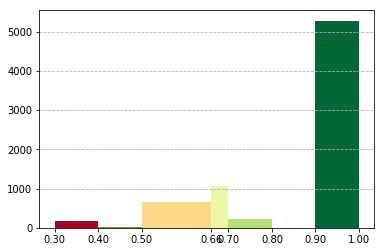

In [13]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.3, 0.4, 0.5, 0.66, 0.7, 0.8, 0.9, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

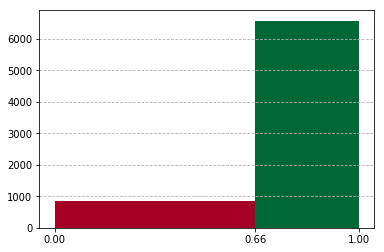

In [14]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.0,  0.66, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

## Results

**Label Distribution**

In [15]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def show_dist(labels):

    plt.figure(figsize=plt.figaspect(1))
    plt.pie(
        labels.value_counts().values,
        labels=labels.value_counts().keys().tolist(),
        radius=2,
        autopct=make_autopct(labels.value_counts().values))
    plt.show()


**All sentences**

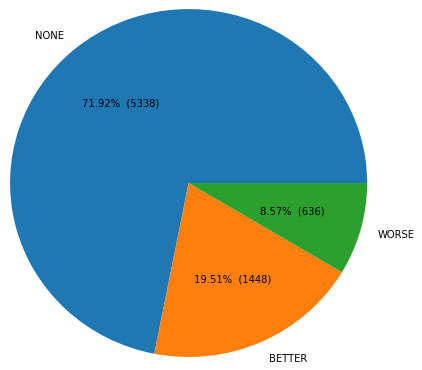

In [16]:
show_dist(aggregated['label'])

**Sentences with conf >= 66**

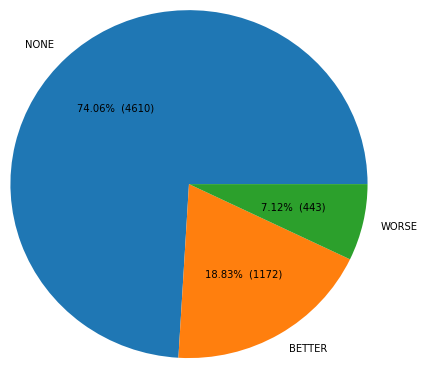

In [17]:
show_dist(useable['label'])